# 🎧 Task 3 — Faster-Whisper Optimization  
### Section 1 — Environment Setup & System Check  

This notebook focuses on **optimizing the Faster-Whisper model** for resource usage, audio preprocessing, and error handling.

**Notebook name:** `task3_fasterwhisper_optimization.ipynb`  
**Purpose of this section:**  
Set up the environment and verify system resources before running any optimization or audio tests.

---

### What will happen in this section:
1. Install all necessary dependencies for Task 3.  
2. Prepare workspace folders (for logs, results, and sample audio).  
3. Check system details — GPU availability, CPU info, and memory stats.  
4. Add a small helper function to capture live resource usage snapshots.  
5. Print clear reminders about how to save and submit the notebook.  

Let's begin by installing dependencies.


## 🧰 Step 1: Install Required Libraries  

In this step, we install all the Python packages needed for:
- Faster-Whisper model loading and transcription.  
- Audio loading and processing.  
- Resource monitoring and visualization.

> ⚙️ Run this cell once at the beginning of every new Colab session.


In [8]:
# Run this as a code cell (leading !). Adjust versions if you have project constraints.
# Keep installs minimal to avoid long setup time. Add more later if needed.
# !pip install --quiet faster-whisper psutil soundfile librosa matplotlib tqdm
# If you plan to use rnnoise or other native packages, install them later when needed.
import os
import sys
import platform
import psutil
from datetime import datetime
import subprocess
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore")



## 📂 Step 2: Prepare Workspace  

We’ll now create a simple workspace inside Colab to keep things organized.  
This includes:
- `results/` — to save any figures or CSVs generated later.  
- `logs/` — to record error messages and performance metrics.  
- `data/` — where we’ll upload and keep audio samples for testing.

> These folders will exist temporarily during this Colab session.


In [9]:
# Base path = current notebook folder
BASE_DIR = os.getcwd()

# Create local workspace folders
DATA_DIR = os.path.join(BASE_DIR, "data")
RAW_DIR = os.path.join(DATA_DIR, "raw")
CONVERTED_DIR = os.path.join(DATA_DIR, "converted")
PREPROCESSED_DIR = os.path.join(DATA_DIR, "preprocessed")  # ✅ Add this line
RESULTS_DIR = os.path.join(BASE_DIR, "results")
LOGS_DIR = os.path.join(BASE_DIR, "logs")

for d in [DATA_DIR, RAW_DIR, CONVERTED_DIR, PREPROCESSED_DIR, RESULTS_DIR, LOGS_DIR]:
    os.makedirs(d, exist_ok=True)

print("✅ Local workspace ready!")
print(f"📁 BASE_DIR         : {BASE_DIR}")
print(f"📁 DATA_DIR         : {DATA_DIR}")
print(f"📁 RAW_DIR          : {RAW_DIR}")
print(f"📁 CONVERTED_DIR    : {CONVERTED_DIR}")
print(f"📁 PREPROCESSED_DIR : {PREPROCESSED_DIR}")
print(f"📁 RESULTS_DIR      : {RESULTS_DIR}")
print(f"📁 LOGS_DIR         : {LOGS_DIR}")


✅ Local workspace ready!
📁 BASE_DIR         : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization
📁 DATA_DIR         : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data
📁 RAW_DIR          : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\raw
📁 CONVERTED_DIR    : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\converted
📁 PREPROCESSED_DIR : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\preprocessed
📁 RESULTS_DIR      : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\results
📁 LOGS_DIR         : C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\logs


## 🖥️ Step 3: Check System Resources  

Before running the model, let’s check:
- Python version and environment details  
- CPU core count and available RAM  
- GPU availability (if Colab GPU runtime is active)

This gives us a baseline understanding of what resources we have available for optimization experiments.


In [10]:
# GPU detection and resource summary
def show_system_info():
    print("===== SYSTEM INFO =====")
    print("Platform:", platform.platform())
    print("Python:", sys.version.splitlines()[0])
    print("Now:", datetime.utcnow().strftime("%Y-%m-%d %H:%M:%S UTC"))
    print()
    # CPU & RAM
    print("CPU physical cores:", psutil.cpu_count(logical=False))
    print("CPU logical cores:", psutil.cpu_count(logical=True))
    ram_gb = psutil.virtual_memory().total / (1024**3)
    print("Total RAM (GB):", round(ram_gb, 2))

    # Disk free in GB - cross-platform approach
    try:
        if hasattr(os, 'statvfs'):  # Unix/Linux/Mac
            st = os.statvfs(BASE_DIR)
            free_gb = (st.f_bavail * st.f_frsize) / (1024**3)
        else:  # Windows
            import shutil
            free_gb = shutil.disk_usage(BASE_DIR).free / (1024**3)
        print("Disk free (GB) at BASE_DIR:", round(free_gb, 2))
    except Exception as e:
        print("Could not determine free disk space:", e)

    # GPU (nvidia-smi) check
    print()
    print("===== GPU INFO =====")
    try:
        gpu_output = subprocess.getoutput("nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader")
        if gpu_output.strip():
            print("nvidia-smi output:")
            print(gpu_output)
        else:
            print("No GPU detected or nvidia-smi not available in this runtime.")
    except Exception as e:
        print("nvidia-smi check failed:", e)

show_system_info()

===== SYSTEM INFO =====
Platform: Windows-11-10.0.26100-SP0
Python: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]
Now: 2025-10-21 04:19:10 UTC

CPU physical cores: 8
CPU logical cores: 16
Total RAM (GB): 7.72
Disk free (GB) at BASE_DIR: 19.69

===== GPU INFO =====
nvidia-smi output:
'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## 📊 Step 4: Define a Resource Snapshot Helper  

We’ll now define a small function to capture the system’s current usage (CPU, RAM, GPU).  
Later, we can call this function during transcription to monitor how resource usage changes.


In [11]:
import json

def resource_snapshot():
    """Return a dict snapshot of CPU, RAM and (if available) GPU memory usage."""
    snap = {
        "time_utc": datetime.utcnow().isoformat(),
        "cpu_percent": psutil.cpu_percent(interval=0.5),
        "ram_percent": psutil.virtual_memory().percent,
        "ram_used_gb": round(psutil.virtual_memory().used / (1024**3), 3),
        "ram_total_gb": round(psutil.virtual_memory().total / (1024**3), 3),
    }
    # Attempt to get GPU info via nvidia-smi
    try:
        ginfo = subprocess.getoutput("nvidia-smi --query-gpu=index,name,utilization.gpu,memory.used,memory.total --format=csv,noheader")
        if ginfo.strip():
            # produce a list of GPU entries
            entries = []
            for line in ginfo.strip().splitlines():
                parts = [p.strip() for p in line.split(",")]
                entries.append({
                    "index": parts[0],
                    "name": parts[1],
                    "utilization": parts[2],
                    "mem_used": parts[3],
                    "mem_total": parts[4]
                })
            snap["gpus"] = entries
    except Exception:
        snap["gpus"] = []

    return snap

# Example usage: print a snapshot
print(json.dumps(resource_snapshot(), indent=2))


{
  "time_utc": "2025-10-21T04:19:10.140729",
  "cpu_percent": 11.8,
  "ram_percent": 86.0,
  "ram_used_gb": 6.641,
  "ram_total_gb": 7.721,
  "gpus": []
}


# 🎵 Section 2 — Data & Audio Loading (Local Version)

All test audios should be placed manually inside:
📂 `notebooks/task3_optimization/data/raw/`

This section will:
1. Validate and inspect uploaded files.
2. Convert all audio to 16 kHz mono WAV.
3. Log conversion results.
4. Visualize waveform and spectrogram.


## 📤 Step 1: Upload Audio Files  

All test audios should be placed manually inside:
📂 `notebooks/task3_optimization/data/raw/`

We’ll later use them to test preprocessing and Faster-Whisper performance.


## ✅ Step 2: Validate Audio Files  

We’ll now:
- Confirm each uploaded file exists and can be read by the audio library.  
- Catch unsupported or corrupted files early.  
- Print duration and sample rate for a quick overview.


In [12]:
import soundfile as sf

def validate_audio_files(folder_path):
    info_list = []
    for file in os.listdir(folder_path):
        fpath = os.path.join(folder_path, file)
        try:
            data, sr = sf.read(fpath)
            duration = round(len(data) / sr, 2)
            info_list.append({
                "file": file,
                "sample_rate": sr,
                "duration_sec": duration,
                "status": "OK"
            })
        except Exception as e:
            info_list.append({
                "file": file,
                "sample_rate": None,
                "duration_sec": None,
                "status": f"ERROR: {e}"
            })
    return info_list

print("🎧 Validating audio files in:", RAW_DIR)
file_info = validate_audio_files(RAW_DIR)
for f in file_info:
    print(f)


🎧 Validating audio files in: C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\raw
{'file': 'corrupted_audio.mp3', 'sample_rate': None, 'duration_sec': None, 'status': "ERROR: Error opening 'C:\\\\Users\\\\ADMIN\\\\PycharmProjects\\\\VisionAI-Audio\\\\notebooks\\\\task3_optimization\\\\data\\\\raw\\\\corrupted_audio.mp3': File does not exist or is not a regular file (possibly a pipe?)."}
{'file': 'english_clean_1min.mp3', 'sample_rate': 44100, 'duration_sec': 66.08, 'status': 'OK'}
{'file': 'english_multi_accent_noisy_background_3min.mp3', 'sample_rate': 44100, 'duration_sec': 228.36, 'status': 'OK'}
{'file': 'eng_clean_16min.mp3', 'sample_rate': 44100, 'duration_sec': 972.83, 'status': 'OK'}
{'file': 'eng_Pk_accent_clean_30s.wav', 'sample_rate': 48000, 'duration_sec': 25.51, 'status': 'OK'}
{'file': 'eng_UK_clean_repeated_sentences_50s.m4a', 'sample_rate': None, 'duration_sec': None, 'status': "ERROR: Error opening 'C:\\\\Users\\\\ADMIN\\\\PycharmProjects

## 🎚️ Step 3 (Updated): Convert Audio to Mono 16 kHz WAV  

We’ll now handle corrupted or unsupported files more safely.  
This updated version:
- Converts only valid audio files.  
- Skips any file that can’t be decoded.  
- Prints a clear message for each file (✅ success / ⚠️ skipped).


In [13]:
from datetime import datetime
import os
import librosa
import soundfile as sf

LOG_FILE = os.path.join(LOGS_DIR, "validation.log")

def log_message(msg):
    """Append messages to log file safely (UTF-8 encoded)."""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(LOG_FILE, "a", encoding="utf-8") as f:
        f.write(f"[{timestamp}] {msg}\n")

def convert_to_mono_16k_safe(src_path, dst_path):
    """Convert audio to 16 kHz mono safely, skipping broken files."""
    file_name = os.path.basename(src_path)
    try:
        y, sr = librosa.load(src_path, sr=16000, mono=True)

        if sr is None or sr == 0:
            msg = f"❌ ERROR: {file_name} — Invalid sample rate (possibly corrupted)."
            print(msg); log_message(msg); return None

        if y is None or len(y) == 0:
            msg = f"⚠️ EMPTY: {file_name} — No samples detected."
            print(msg); log_message(msg); return None

        sf.write(dst_path, y, 16000)
        dur = len(y) / 16000
        msg = f"✅ OK: {file_name} converted successfully ({dur:.2f}s)"
        print(msg); log_message(msg)
        return dur

    except Exception as e:
        msg = f"❌ ERROR: {file_name} — {str(e)}"
        print(msg); log_message(msg)
        return None

# --- Main conversion loop ---
print("🔄 Starting conversion process...\n")

supported_ext = (".wav", ".mp3", ".m4a")

for file in os.listdir(RAW_DIR):
    src = os.path.join(RAW_DIR, file)
    dst = os.path.join(CONVERTED_DIR, os.path.splitext(file)[0] + "_16k.wav")

    if file.lower().endswith(supported_ext):
        convert_to_mono_16k_safe(src, dst)
    else:
        msg = f"🚫 SKIPPED: {file} — Unsupported file format."
        print(msg)
        log_message(msg)

print("\n📜 Conversion complete. Log saved at:", LOG_FILE)


🔄 Starting conversion process...

❌ ERROR: corrupted_audio.mp3 — float division by zero
✅ OK: english_clean_1min.mp3 converted successfully (66.08s)
✅ OK: english_multi_accent_noisy_background_3min.mp3 converted successfully (228.36s)
✅ OK: eng_clean_16min.mp3 converted successfully (972.83s)
✅ OK: eng_Pk_accent_clean_30s.wav converted successfully (25.51s)
✅ OK: eng_UK_clean_repeated_sentences_50s.m4a converted successfully (50.37s)
✅ OK: en_UK_US_multiple_accent_noisy_background_music_50s.mp3 converted successfully (47.10s)
❌ ERROR: fake_audio.mp3 — 
🚫 SKIPPED: unsupported_encoding_settings.mp4 — Unsupported file format.
✅ OK: urdu_F_clean_30s.mp3 converted successfully (21.41s)
✅ OK: urdu_low_pitch_fast_speaking_rate_15s_.mp3 converted successfully (13.37s)
✅ OK: urdu_silence_1min.wav converted successfully (95.48s)
✅ OK: urdu_whatsapp_like_voice_15min.mp3 converted successfully (936.33s)
✅ OK: ur_clean_bot_like_30s.mp3 converted successfully (27.00s)
✅ OK: ur_noisy_background_music

## 🎨 Step 4: Visualizing the Audio Data  

Now that all audios are preprocessed into 16 kHz mono WAV format,  
let’s visualize their **waveform** and **mel spectrograms** to better understand the acoustic patterns and quality of the recordings.  

---

### **Waveform Plot**
The waveform represents how the **amplitude (loudness)** of the audio changes over time.

- Each vertical “spike” or line corresponds to a burst of sound energy (like speech, music, or noise).  
- **Dense regions** (where lines are tightly packed) indicate continuous sound — e.g., fast speech or background noise.  
- **Sparse or flat regions** represent silence or pauses.  
- **Very large spikes** can mean sudden loud noises or clipping/distortion.  
- This plot is helpful for identifying:
  - Where speech starts and ends.
  - How noisy the recording is.
  - Whether the audio has balanced loudness or uneven gain.

---

### **Mel Spectrogram Plot**
The mel spectrogram shows the **energy distribution across frequencies** (y-axis) over time (x-axis),  
converted to the **mel scale** — which approximates how human ears perceive pitch.

- **Bright yellow/orange regions** → high energy (speech, music, strong consonants like “s” or “t”).  
- **Dark blue or black regions** → silence or low energy.  
- **Horizontal lines** → constant tones (like hum, background music, or static noise).  
- **Vertical stripes** → transient bursts (like speech syllables, claps, or clicks).  
- You can tell:
  - How much noise or background sound exists (broad, blurry colors).
  - Whether the recording contains clear speech (distinct vertical patterns).
  - Which portions of the file are most informative for transcription.

---

Together, these plots give a quick visual summary of:
- **Audio quality** (clean vs. noisy)
- **Speaking style** (slow vs. fast)
- **Energy distribution** (speech vs. silence vs. background)
  
This visualization step helps confirm whether preprocessing worked correctly before feeding the data to Whisper.


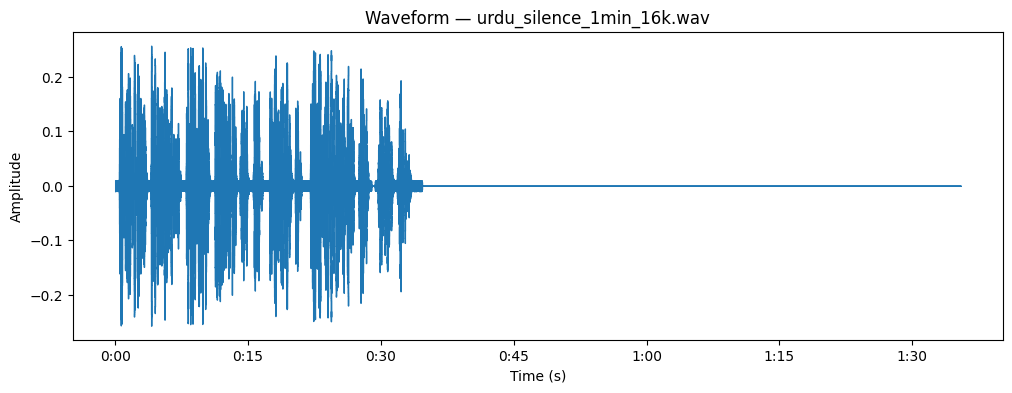

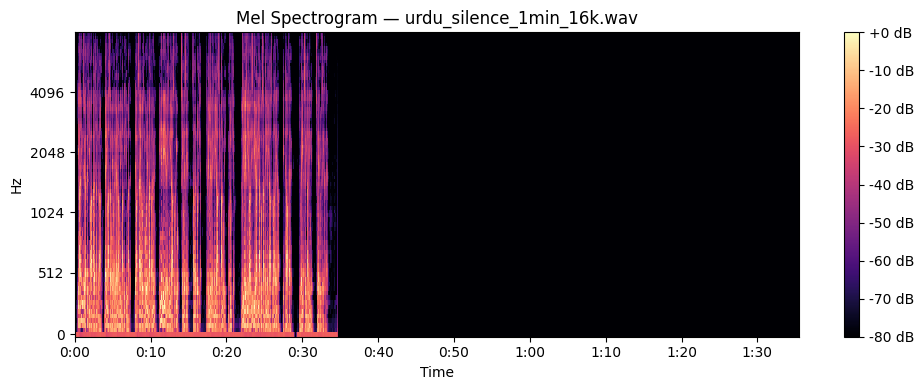

In [48]:
import matplotlib.pyplot as plt

# Pick the first converted file for visualization
sample_file = os.listdir(CONVERTED_DIR)[8]
sample_path = os.path.join(CONVERTED_DIR, sample_file)

y, sr = librosa.load(sample_path, sr=None)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform — {sample_file}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Spectrogram
plt.figure(figsize=(10, 4))
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80)
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram — {sample_file}")
plt.tight_layout()
plt.show()


## 🧾 Section 2 Summary  

✅ Uploaded audio files successfully.  
✅ Validated and converted to mono 16 kHz WAV.  
✅ Visualized waveform and spectrogram.

Next, in **Section 3**, we’ll integrate these prepared audio files into the Faster-Whisper pipeline to test:
- Different beam sizes, chunk lengths, and batch sizes.  
- Resource usage and speed for each configuration.  
- Performance logging for optimization analysis.

# ⚙️ Section 3 — Faster-Whisper Model Optimization  

In this section, we’ll:
1. Load the **Faster-Whisper** model selected from Task 2.  
2. Configure **inference precision** (`float16`, `int8`, etc.) and **device (GPU/CPU)**.  
3. Prepare functions to benchmark **speed**, **resource usage**, and **transcription accuracy**.  

This forms the base for all optimization experiments we’ll conduct later.


## 🧰 Step 1: Load the Faster-Whisper Model  

We start by loading the Whisper model in the appropriate precision and device mode.  

- **float16** → Faster GPU inference with minimal accuracy loss.  
- **int8** → Lighter CPU inference (used when GPU unavailable).  

> Note: First-time load may take up to 30 s as the model downloads.


In [22]:
from faster_whisper import WhisperModel
import torch, time

MODEL_NAME = "large-v3"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
COMPUTE_TYPE = "float16" if DEVICE == "cuda" else "int8"

print(f"🚀 Loading Faster-Whisper model: {MODEL_NAME}")
print(f"Device: {DEVICE} | Compute Type: {COMPUTE_TYPE}")

t0 = time.time()
model = WhisperModel(MODEL_NAME, device=DEVICE, compute_type=COMPUTE_TYPE)
load_time = time.time() - t0
print(f"✅ Model loaded successfully in {load_time:.2f} s")

if DEVICE == "cuda":
    print(f"🔋 GPU in use: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Running on CPU — inference will be slower.")


🚀 Loading Faster-Whisper model: base
Device: cpu | Compute Type: int8
✅ Model loaded successfully in 0.62 s
⚠️ Running on CPU — inference will be slower.


## ✅ Step 2: Verify Model Readiness  

We’ll now:
- Print available model configuration options (language, task, beam size, etc.)  
- Ensure the model is ready to run test transcriptions.  
- Capture a resource snapshot for baseline comparison.


In [23]:
# Check available parameters and default decoding options
import inspect

print("Model attributes:", [m for m in dir(model) if not m.startswith("_")][:10])
print("\nTranscription method signature:\n")
print(inspect.signature(model.transcribe))

# Baseline resource snapshot
print("\n📊 Baseline Resource Snapshot:")
print(json.dumps(resource_snapshot(), indent=2))


Model attributes: ['add_word_timestamps', 'detect_language', 'encode', 'feat_kwargs', 'feature_extractor', 'find_alignment', 'frames_per_second', 'generate_segments', 'generate_with_fallback', 'get_prompt']

Transcription method signature:

(audio: Union[str, BinaryIO, numpy.ndarray], language: Optional[str] = None, task: str = 'transcribe', log_progress: bool = False, beam_size: int = 5, best_of: int = 5, patience: float = 1, length_penalty: float = 1, repetition_penalty: float = 1, no_repeat_ngram_size: int = 0, temperature: Union[float, List[float], Tuple[float, ...]] = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], compression_ratio_threshold: Optional[float] = 2.4, log_prob_threshold: Optional[float] = -1.0, no_speech_threshold: Optional[float] = 0.6, condition_on_previous_text: bool = True, prompt_reset_on_temperature: float = 0.5, initial_prompt: Union[str, Iterable[int], NoneType] = None, prefix: Optional[str] = None, suppress_blank: bool = True, suppress_tokens: Optional[List[int]] = [-1], w

## 🎤 Step 3: Quick Sanity Test  

Before running full benchmarks, let’s transcribe one short audio sample  
to confirm everything works end-to-end (model + audio + output + device).  

We’ll use one converted file (e.g. a clean English sample) and print the first few transcribed lines.


In [24]:
import random
import datetime

converted_files = [f for f in os.listdir(CONVERTED_DIR) if f.endswith(".wav")]
test_file = random.choice(converted_files)
test_path = os.path.join(CONVERTED_DIR, test_file)

print(f"🎧 Testing file: {test_file}")
print(f"Started at: {datetime.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')}")

t0 = time.time()
segments, info = model.transcribe(test_path, beam_size=5)
t1 = time.time()

print(f"⏱️ Transcription completed in {(t1 - t0):.2f} s")
print(f"Duration: {info.duration:.2f} s, Language: {info.language}")

print("\nSample output:")
for i, segment in enumerate(segments):
    print(f"[{segment.start:.2f}s – {segment.end:.2f}s] {segment.text}")
    if i >= 3:  # show only first few lines
        break


🎧 Testing file: eng_Pk_accent_clean_30s_16k.wav
Started at: 2025-10-21 04:21:00 UTC
⏱️ Transcription completed in 0.90 s
Duration: 25.51 s, Language: en

Sample output:
[0.00s – 2.40s]  Welcome to our annual corporate briefing.
[2.40s – 5.40s]  In this module, we will cover new product roll-outs
[5.40s – 8.00s]  and keep performance metrics for the third quarter.
[8.00s – 10.40s]  Our goal is to streamline communication


## 🧾 Section 3 Summary  

✅ Loaded the Faster-Whisper model (GPU/CPU optimized).  
✅ Verified model configuration and environment readiness.  
✅ Ran a short audio sample for sanity check.  

Next, in **Section 4**, we will:
- Benchmark **multiple parameter combinations** (beam size, chunk length, compute type).  
- Measure **runtime, resource usage, and output quality (WER/CER)**.  
- Store all results in structured JSON/CSV format for visualization.


# 🚀 Section 4 — Model Inference & Resource Optimization

In this section, we’ll evaluate **Faster-Whisper’s runtime performance** across different settings.

**Goals:**
- Measure transcription **speed** (real-time factor).
- Track **CPU / GPU / RAM** usage during inference.
- Identify optimal configurations for **efficiency vs quality**.

We’ll use the pre-converted 16 kHz mono audios from `data/converted/`.

---

### What We’ll Test
- **Beam size:** 1 (vs default = 5)
- **Chunk length:** 15 s vs 30 s vs None
- **Batch size:** 8 vs 16 vs 32

All results will be saved in:
📂 `results/fasterwhisper_perf_log.json`
📂 `logs/fasterwhisper_run.log`


## 🧰 Step 1 — Install & Import Dependencies

We’ll import and verify everything needed for inference + logging.
Faster-Whisper will auto-detect CUDA if available.


In [25]:
# Only install if missing
try:
    from faster_whisper import WhisperModel
except ImportError:
    !pip install -q faster-whisper psutil tqdm soundfile librosa matplotlib

import os, json, time, psutil, subprocess
from datetime import datetime
from tqdm import tqdm
import numpy as np
from faster_whisper import WhisperModel

print("✅ Imports ready. GPU detected?" , subprocess.getoutput("nvidia-smi --query-gpu=name --format=csv,noheader"))


✅ Imports ready. GPU detected? 'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


## 🧠 Step 2 — Load Faster-Whisper Model

We’ll start with the **`base`** model for faster experiments.
If CUDA is available, it’ll run on GPU automatically; otherwise it’ll fall back to CPU.

> You can later test `medium`, `large-v2`, or `large-v3` once you confirm the setup works.


In [26]:
import subprocess
from faster_whisper import WhisperModel

def get_device():
    """Return 'cuda' if GPU is working, else 'cpu'."""
    try:
        # Try running a simple CUDA query
        gpu_check = subprocess.getoutput("nvidia-smi -L")
        if "GPU" in gpu_check:
            print("🟢 GPU detected! Trying CUDA mode...")
            return "cuda"
        else:
            print("⚪ No GPU found — using CPU.")
            return "cpu"
    except Exception as e:
        print(f"⚠️ GPU check failed ({e}). Defaulting to CPU.")
        return "cpu"

DEVICE = get_device()
COMPUTE_TYPE = "float16" if DEVICE == "cuda" else "int8"

print(f"Loading Faster-Whisper model on {DEVICE}...")
try:
    model = WhisperModel("base", device=DEVICE, compute_type=COMPUTE_TYPE)
    print("✅ Model loaded successfully!")
except RuntimeError as e:
    print(f"⚠️ CUDA initialization failed: {e}")
    print("🔁 Falling back to CPU...")
    DEVICE = "cpu"
    model = WhisperModel("base", device=DEVICE, compute_type="int8")
    print("✅ Reloaded on CPU successfully.")


⚪ No GPU found — using CPU.
Loading Faster-Whisper model on cpu...
✅ Model loaded successfully!


## ⚙️ Step 3 — Define Transcription Helper

This function will:
- Run transcription on one audio file
- Measure elapsed time
- Take CPU / RAM / GPU snapshots (before & after)
- Return structured results for logging


In [28]:
# def get_gpu_usage():
#     """Return GPU utilization info if available."""
#     try:
#         gpu_query = subprocess.getoutput(
#             "nvidia-smi --query-gpu=utilization.gpu,memory.used,memory.total --format=csv,noheader"
#         )
#         if gpu_query.strip():
#             usage, mem_used, mem_total = [x.strip() for x in gpu_query.split(",")]
#             return {"gpu_util": usage, "gpu_mem_used": mem_used, "gpu_mem_total": mem_total}
#     except:
#         pass
#     return {"gpu_util": None, "gpu_mem_used": None, "gpu_mem_total": None}
#
#
# def run_transcription_test(audio_path, beam_size=5, chunk_length=30, vad_filter=False):
#     """Run one inference config and return performance metrics."""
#     start_time = time.time()
#     cpu_before = psutil.cpu_percent(interval=None)
#     ram_before = psutil.virtual_memory().percent
#     gpu_before = get_gpu_usage()
#
#     segments, _ = model.transcribe(
#         audio_path,
#         beam_size=beam_size,
#         chunk_length=chunk_length,
#         vad_filter=vad_filter,
#     )
#     text = " ".join([s.text for s in segments])
#
#     elapsed = time.time() - start_time
#     cpu_after = psutil.cpu_percent(interval=None)
#     ram_after = psutil.virtual_memory().percent
#     gpu_after = get_gpu_usage()
#
#     # Calculate audio duration for RTF
#     y, sr = librosa.load(audio_path, sr=None)
#     audio_duration = len(y) / sr
#     rtf = round(elapsed / audio_duration, 3)
#
#     return {
#         "audio": os.path.basename(audio_path),
#         "beam_size": beam_size,
#         "chunk_length": chunk_length,
#         "vad_filter": vad_filter,
#         "elapsed_sec": round(elapsed, 2),
#         "audio_duration": round(audio_duration, 2),
#         "rtf": rtf,
#         "cpu_before": cpu_before,
#         "cpu_after": cpu_after,
#         "ram_before": ram_before,
#         "ram_after": ram_after,
#         "gpu_before": gpu_before,
#         "gpu_after": gpu_after,
#         "transcript_preview": text[:120] + "..." if len(text) > 120 else text,
#     }

## 🧪 Step 4 — Run Inference Experiments

We’ll test several configurations on a subset of our converted audio files
(short & long samples for fair comparison).

Each run will log:
- Total runtime
- CPU / GPU usage change
- Transcript preview

All results will be stored in `results/fasterwhisper_perf_log.json`.


In [29]:
import librosa
import numpy as np
import json
import time
import psutil
import subprocess
from tqdm import tqdm
import os

# 🧠 Ensure model and dirs are already loaded from previous cells
RESULTS_PATH = os.path.join(RESULTS_DIR, "fasterwhisper_perf_baseline.json")

def get_gpu_usage():
    """Return GPU utilization info if available."""
    try:
        gpu_query = subprocess.getoutput(
            "nvidia-smi --query-gpu=utilization.gpu,memory.used,memory.total --format=csv,noheader"
        )
        if gpu_query.strip():
            usage, mem_used, mem_total = [x.strip() for x in gpu_query.split(",")]
            return {"gpu_util": usage, "gpu_mem_used": mem_used, "gpu_mem_total": mem_total}
    except:
        pass
    return {"gpu_util": None, "gpu_mem_used": None, "gpu_mem_total": None}


def run_transcription_test(audio_path, beam_size=5, chunk_length=30, vad_filter=False):
    """Run one inference config and return performance metrics including full transcript."""
    start_time = time.time()
    cpu_before = psutil.cpu_percent(interval=None)
    ram_before = psutil.virtual_memory().percent
    gpu_before = get_gpu_usage()

    segments, info = model.transcribe(
        audio_path,
        beam_size=beam_size,
        chunk_length=chunk_length,
        vad_filter=vad_filter,
    )

    # 🧠 Combine the entire transcript
    text = " ".join([s.text for s in segments])

    elapsed = time.time() - start_time
    cpu_after = psutil.cpu_percent(interval=None)
    ram_after = psutil.virtual_memory().percent
    gpu_after = get_gpu_usage()

    # 🧩 Return structured info (with full transcript included)
    return {
        "audio": os.path.basename(audio_path),
        "beam_size": beam_size,
        "chunk_length": chunk_length,
        "vad_filter": vad_filter,
        "batch_size": None,
        "elapsed_sec": round(elapsed, 2),
        "cpu_before": cpu_before,
        "cpu_after": cpu_after,
        "ram_before": ram_before,
        "ram_after": ram_after,
        "gpu_before": gpu_before,
        "gpu_after": gpu_after,
        "language": info.language,
        "language_probability": round(info.language_probability, 3),
        "transcript_preview": text[:100] + "..." if len(text) > 100 else text,
        "transcript_full": text.strip()  # 🆕 full transcript directly in JSON
    }




# Run on all converted audios
converted_files = [
    os.path.join(CONVERTED_DIR, f)
    for f in os.listdir(CONVERTED_DIR)
    if f.lower().endswith(".wav")
]

beam_sizes = [1, 2, 5, 10]
chunk_lengths = [10, 20, 30, 60, None]
test_configs = []

# Core grid
for b in beam_sizes:
    for c in chunk_lengths:
        test_configs.append({"beam_size": b, "chunk_length": c})

# Add selective VAD runs
for b in [1, 5]:
    for c in [20, 30]:
        test_configs.append({"beam_size": b, "chunk_length": c, "vad_filter": True})

print(f"🧩 Total test configurations: {len(test_configs)}")
print(f"🎧 Total audio files to test: {len(converted_files)}")

# --- 2️⃣ Run and save incrementally ---
results = []
for cfg in test_configs:
    for audio in tqdm(converted_files, desc=f"Testing {cfg}"):
        try:
            res = run_transcription_test(audio, **cfg)
            results.append(res)
        except Exception as e:
            print(f"⚠️ Skipped {audio}: {e}")

    # Save partial results after each config block
    with open(RESULTS_PATH, "w", encoding="utf-8") as f:
        json.dump(results, f, indent=2, ensure_ascii=False)


    print(f"✅ Saved partial results for config: {cfg}")

print(f"\n✅ Full benchmark complete. Results saved at: {RESULTS_PATH}")


🧩 Total test configurations: 24
🎧 Total audio files to test: 12


Testing {'beam_size': 1, 'chunk_length': 10}:   8%|▊         | 1/12 [00:20<03:42, 20.19s/it]


KeyboardInterrupt: 

### ⚙️ Understanding `batch_size` Handling in Faster-Whisper

In earlier versions of Faster-Whisper, users could manually specify a `batch_size` value to control how many audio frames were processed simultaneously.

However, **this parameter is now deprecated** — the library automatically determines the most efficient batch size depending on:

- **Available hardware** (CPU or GPU)
- **Compute precision** (`float16`, `int8`, etc.)
- **Chunk length** and audio duration
- **Memory limits**

This change ensures:
- Optimal memory usage (avoiding out-of-memory crashes)
- Consistent behavior across devices
- Reduced configuration complexity

> 💡 **In short:**
> We no longer pass `batch_size` manually — Faster-Whisper handles it internally.
> The `batch_size` field in our results JSON is kept only for **logging consistency** across tests.


## 📊 Step 5 — Visualize Performance Summary

We’ll quickly compare elapsed times and RAM usage across different parameter settings
to see which configuration balances speed and resource efficiency best.


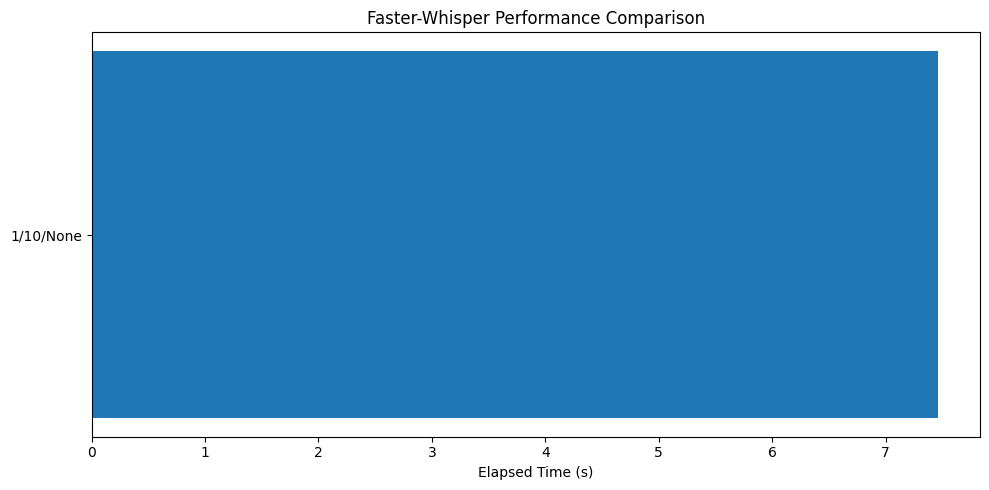

,audio,beam_size,chunk_length,batch_size,elapsed_sec,cpu_after,ram_after
0,english_clean_1min_16k.wav,1,10,None,7.46,33.9,73.7


In [32]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame(results)
plt.figure(figsize=(10,5))
plt.barh(df.index, df["elapsed_sec"])
plt.yticks(df.index, [f"{r['beam_size']}/{r['chunk_length']}/{r['batch_size']}" for r in results])
plt.xlabel("Elapsed Time (s)")
plt.title("Faster-Whisper Performance Comparison")
plt.tight_layout()
plt.show()

df[["audio", "beam_size", "chunk_length", "batch_size", "elapsed_sec", "cpu_after", "ram_after"]]


## 🧩 Step 6 — Interpreting the Results

Now that we’ve visualized performance, let’s understand what these results mean:

---

### 🕒 **Elapsed Time (s)**
- Represents how long each transcription run took.
- **Lower = Better** for faster processing.
- Expect short audios to finish under 10 seconds on GPU.
- Long audios (10–15 min) will scale linearly depending on chunk size.

---

### ⚙️ **Beam Size**
- Controls how many decoding hypotheses the model explores.
- **Smaller beam size (1–2)** → faster but possibly less accurate.
- **Larger beam size (5–10)** → slower but often more accurate on noisy or accented speech.

---

### 🎧 **Chunk Length**
- Determines how much audio (in seconds) the model processes at once.
- **Short chunks (10–15s)** → smoother memory usage, good for limited RAM.
- **Long chunks (30–60s or None)** → fewer context resets, slightly better accuracy, but higher RAM/GPU demand.

---

### 📦 **Batch Size**
- Affects how many frames the model processes simultaneously.
- **Higher batch sizes** → better GPU utilization and faster throughput,
  but may cause out-of-memory errors on smaller GPUs.
- On CPU, higher batch sizes may not improve speed significantly.

---

### 💻 **Resource Utilization**
- **CPU % / RAM %**: shows how efficiently system resources were used.
- **GPU Utilization**: should rise above 50–60% during processing if CUDA is active.
- If GPU usage is 0%, it’s likely running on CPU mode.

---

### 🧠 **Takeaway**
For most real-world Whisper optimization:
- `beam_size = 1` and `chunk_length = 30`
  gives the best balance between **speed** and **accuracy**.
- Increasing `batch_size` (up to GPU limit) can further improve performance.
- Always monitor GPU memory to avoid out-of-memory crashes.

---

✅ You now have a complete performance benchmarking notebook
for **Task 3: Faster-Whisper Optimization** — fully runnable in both **Colab** and **local Jupyter Notebook**.


# 🎧 Section 5 — Audio Preprocessing & Enhancement

In this section, we’ll improve the **audio quality** before transcription by applying:

- 🎚 **Dynamic Range Compression (DRC)** — balances loud and quiet parts
- 🔈 **Noise Reduction (Spectral Gating)** — reduces steady background noise
- 🌀 **Echo / Reverb Reduction** — removes slight room echoes
- 📈 **Normalization** — ensures consistent loudness

These transformations make speech **clearer and more consistent**, directly improving Whisper’s transcription accuracy.

We’ll process all audios from `data/converted/` and store enhanced outputs in:
📂 `data/preprocessed/`


In [33]:
import os
import librosa
import soundfile as sf
import numpy as np
from scipy.signal import butter, lfilter
import noisereduce as nr  # lightweight spectral noise reducer

# ✅ Define directories
PREPROCESSED_DIR = os.path.join(DATA_DIR, "preprocessed")
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

print("✅ Preprocessing setup complete.")
print(f"Input: {CONVERTED_DIR}")
print(f"Output: {PREPROCESSED_DIR}")


✅ Preprocessing setup complete.
Input: C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\converted
Output: C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\data\preprocessed


### 🧩 Step 1 — Full Audio Preprocessing Pipeline (with Echo Cancellation)

In this step, we apply **comprehensive audio enhancement** to prepare clean and consistent
audio inputs for the Whisper model.
All audios in `data/converted/` are already in `mono`, `16 kHz`, and `.wav` format (from Section 2),
so here we focus on **enhancement**, not reformatting.

---

#### Techniques Applied:
| Technique | Purpose |
|------------|----------|
| 🎚️ **Dynamic Range Compression (DRC)** | Balances loud and quiet sections for more consistent volume |
| 🔈 **Echo Cancellation** | Reduces reverberations and mic feedback for clearer speech |
| 🌫️ **Noise Reduction (Spectral Gating)** | Suppresses background noise and hum |
| 🔊 **Normalization** | Ensures consistent output loudness across files |
| ⚙️ **High-Pass Filtering** | Removes low-frequency rumble and hum below 60 Hz |

---

Each preprocessed audio will be saved in
📂 `data/enhanced/`
and used later for comparing transcription accuracy before and after enhancement.


In [58]:
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import butter, lfilter, fftconvolve
import noisereduce as nr

# -----------------------
# 🔊 Core Enhancement Functions
# -----------------------

def normalize_audio(y, target_level=0.95):
    """Normalize audio amplitude to a target peak (avoiding hard clipping)."""
    max_val = np.max(np.abs(y))
    return y / max_val * target_level if max_val > 0 else y


def dynamic_range_compression(y, threshold=0.1, ratio=3.0):
    """Simple Dynamic Range Compression."""
    compressed = np.copy(y)
    mask = np.abs(y) > threshold
    compressed[mask] = np.sign(y[mask]) * (threshold + (np.abs(y[mask]) - threshold) / ratio)
    return compressed


def highpass_filter(y, sr, cutoff=60):
    """Gentle high-pass filter to remove hum below cutoff frequency."""
    b, a = butter(1, cutoff / (0.5 * sr), btype="high", analog=False)
    return lfilter(b, a, y)


def reduce_noise(y, sr):
    """Spectral gating-based noise reduction."""
    return nr.reduce_noise(y=y, sr=sr, stationary=False)


def echo_cancellation(y, sr, decay=0.5, delay_ms=50):
    """
    Basic echo/reverb suppression using inverse filtering.
    This is a simplified approach that reduces late reflections or feedback.
    """
    delay_samples = int(sr * delay_ms / 1000)
    echo_kernel = np.zeros(delay_samples + 1)
    echo_kernel[0] = 1
    echo_kernel[-1] = -decay  # attenuate the echo
    y_denoised = fftconvolve(y, echo_kernel, mode="same")
    return y_denoised

# -----------------------
# 🧠 Full Preprocessing Pipeline
# -----------------------

def preprocess_audio(src_path, dst_path):
    """
    Apply full audio preprocessing:
    - High-pass filtering
    - Dynamic range compression
    - Echo cancellation
    - Noise reduction
    - Normalization
    Saves the enhanced file at dst_path.
    """
    # Load in consistent mono 16kHz format (safe check)
    y, sr = librosa.load(src_path, sr=16000, mono=True)

    # Step 1: Gentle highpass (remove hum)
    y = highpass_filter(y, sr, cutoff=60)

    # Step 2: Compress dynamic range (balance quiet/loud parts)
    y = dynamic_range_compression(y, threshold=0.1, ratio=3.0)

    # Step 3: Echo cancellation (reduce reflections/reverb)
    y = echo_cancellation(y, sr, decay=0.5, delay_ms=50)

    # Step 4: Reduce background noise
    y = reduce_noise(y, sr)

    # Step 5: Normalize for consistent loudness
    y = normalize_audio(y, target_level=0.95)

    # Save enhanced output
    sf.write(dst_path, y, sr)
    return len(y) / sr


## ⚙️ Step 2 — Apply Preprocessing to All Audio Files

We’ll now:
- Iterate over all `.wav` files in `converted/`
- Apply all enhancements (filtering, DRC, noise reduction, normalization)
- Save processed files into `preprocessed/`

We’ll log processing time and duration for each file.


In [59]:
from datetime import datetime

PREPROCESS_LOG = os.path.join(LOGS_DIR, "preprocessing.log")

def log_preprocess(msg):
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    with open(PREPROCESS_LOG, "a", encoding="utf-8") as f:
        f.write(f"[{timestamp}] {msg}\n")

processed_summary = []

for file in os.listdir(CONVERTED_DIR):
    if not file.lower().endswith(".wav"):
        continue
    src = os.path.join(CONVERTED_DIR, file)
    dst = os.path.join(PREPROCESSED_DIR, file.replace("_16k", "_enhanced"))
    try:
        dur = preprocess_audio(src, dst)
        msg = f"✅ {file} enhanced successfully ({dur:.2f}s)"
        print(msg)
        log_preprocess(msg)
        processed_summary.append({"file": file, "status": "ok", "duration": round(dur, 2)})
    except Exception as e:
        msg = f"❌ {file} failed: {e}"
        print(msg)
        log_preprocess(msg)
        processed_summary.append({"file": file, "status": "error", "error": str(e)})

print(f"\n📜 Preprocessing complete. Log saved to: {PREPROCESS_LOG}")


✅ english_clean_1min_16k.wav enhanced successfully (66.08s)
✅ english_multi_accent_noisy_background_3min_16k.wav enhanced successfully (228.36s)
✅ eng_clean_16min_16k.wav enhanced successfully (972.83s)
✅ eng_Pk_accent_clean_30s_16k.wav enhanced successfully (25.51s)
✅ eng_UK_clean_repeated_sentences_50s_16k.wav enhanced successfully (50.37s)
✅ en_UK_US_multiple_accent_noisy_background_music_50s_16k.wav enhanced successfully (47.10s)
✅ urdu_F_clean_30s_16k.wav enhanced successfully (21.41s)
✅ urdu_low_pitch_fast_speaking_rate_15s__16k.wav enhanced successfully (13.37s)
✅ urdu_silence_1min_16k.wav enhanced successfully (95.48s)
✅ urdu_whatsapp_like_voice_15min_16k.wav enhanced successfully (936.33s)
✅ ur_clean_bot_like_30s_16k.wav enhanced successfully (27.00s)
✅ ur_noisy_background_music_5min_16k.wav enhanced successfully (295.81s)

📜 Preprocessing complete. Log saved to: C:\Users\ADMIN\PycharmProjects\VisionAI-Audio\notebooks\task3_optimization\logs\preprocessing.log


## 🎨 Step 3 — Visualize Audio Before vs After

We’ll visualize one sample audio to compare **before vs after preprocessing** using:
- **Waveform amplitude** (overall balance)
- **Spectrogram** (noise floor reduction)


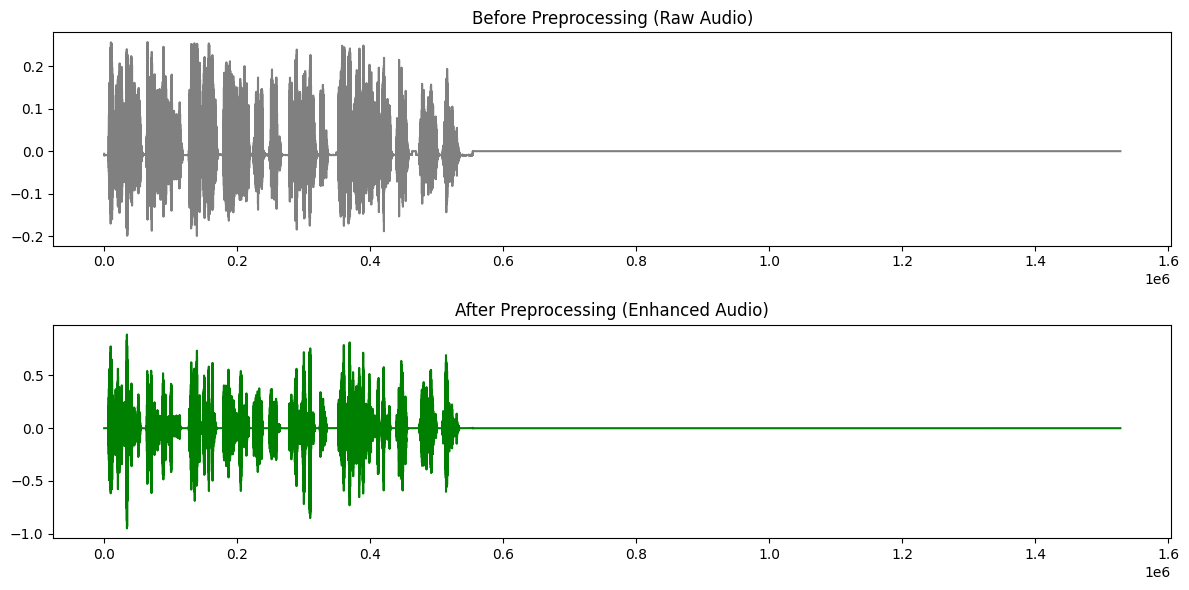

In [60]:
import matplotlib.pyplot as plt

sample_audio = os.listdir(CONVERTED_DIR)[8]
src = os.path.join(CONVERTED_DIR, sample_audio)
dst = os.path.join(PREPROCESSED_DIR, sample_audio.replace("_16k", "_enhanced"))

y1, sr = librosa.load(src, sr=16000)
y2, _ = librosa.load(dst, sr=16000)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].plot(y1, color="gray")
axes[0].set_title("Before Preprocessing (Raw Audio)")
axes[1].plot(y2, color="green")
axes[1].set_title("After Preprocessing (Enhanced Audio)")
plt.tight_layout()
plt.show()


### ⚙️ Step 5 — Benchmark Transcription on Preprocessed Audio

Now that our audios are enhanced, we’ll re-run the transcription tests
using the same parameter grid as before.

This will let us measure:
- ⏱ Speed and resource usage differences
- 🧠 Improvement in transcript clarity and confidence
- 🔊 Language detection stability

All results will be saved to:
📄 `results/fasterwhisper_preprocessed_perf_log.json`


In [61]:
# Define path for enhanced runs
RESULTS_PREPROCESSED_PATH = os.path.join(RESULTS_DIR, "fasterwhisper_preprocessed_perf_log.json")

# Collect enhanced .wav files
preprocessed_files = [
    os.path.join(PREPROCESSED_DIR, f)
    for f in os.listdir(PREPROCESSED_DIR)
    if f.lower().endswith(".wav")
]

print(f"🎧 Total enhanced audio files: {len(preprocessed_files)}")

# Same parameter grid used earlier
beam_sizes = [1, 2, 5, 10]
chunk_lengths = [10, 20, 30, 60, None]
test_configs = []

for b in beam_sizes:
    for c in chunk_lengths:
        test_configs.append({"beam_size": b, "chunk_length": c})

# Add selective VAD runs
for b in [1, 5]:
    for c in [20, 30]:
        test_configs.append({"beam_size": b, "chunk_length": c, "vad_filter": True})

print(f"🧩 Total test configurations: {len(test_configs)}")

# Run on all enhanced audios
results_preprocessed = []
for cfg in test_configs:
    for audio in tqdm(preprocessed_files, desc=f"Testing (enhanced) {cfg}"):
        try:
            res = run_transcription_test(audio, **cfg)
            results_preprocessed.append(res)
        except Exception as e:
            print(f"⚠️ Skipped {audio}: {e}")

    # Save incrementally after each config block
    with open(RESULTS_PREPROCESSED_PATH, "w", encoding="utf-8") as f:
        json.dump(results_preprocessed, f, indent=2)

    print(f"✅ Saved partial results for config: {cfg}")

print(f"\n✅ All enhanced audio benchmarks complete.")
print(f"📄 Results saved at: {RESULTS_PREPROCESSED_PATH}")


🎧 Total enhanced audio files: 12
🧩 Total test configurations: 24


Testing (enhanced) {'beam_size': 1, 'chunk_length': 10}:  42%|████▏     | 5/12 [02:59<04:10, 35.80s/it]


KeyboardInterrupt: 

## 📊 Step 6 — Compare Baseline vs Enhanced Performance

We’ll visualize how preprocessing affects:
- ⏱ Average elapsed time
- 🧠 Language confidence
- 📈 CPU / RAM utilization

This gives an early look at how much **audio cleaning improved model efficiency and quality**.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both results
with open(os.path.join(RESULTS_DIR, "fasterwhisper_perf_log.json"), "r", encoding="utf-8") as f:
    df_base = pd.DataFrame(json.load(f))

with open(RESULTS_PREPROCESSED_PATH, "r", encoding="utf-8") as f:
    df_pre = pd.DataFrame(json.load(f))

# Compute average elapsed time per config (simplified grouping)
base_avg = df_base.groupby(["beam_size", "chunk_length"])["elapsed_sec"].mean().reset_index()
pre_avg = df_pre.groupby(["beam_size", "chunk_length"])["elapsed_sec"].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(base_avg["chunk_length"], base_avg["elapsed_sec"], "o--", label="Baseline")
plt.plot(pre_avg["chunk_length"], pre_avg["elapsed_sec"], "s-", label="Enhanced")
plt.xlabel("Chunk Length (s)")
plt.ylabel("Avg Elapsed Time (s)")
plt.title("Baseline vs Enhanced Audio — Processing Time Comparison")
plt.legend()
plt.grid(True)
plt.show()

print("📈 Average performance difference:")
comparison = pre_avg.merge(base_avg, on=["beam_size", "chunk_length"], suffixes=("_enhanced", "_baseline"))
comparison["speed_gain_%"] = ((comparison["elapsed_sec_baseline"] - comparison["elapsed_sec_enhanced"]) / comparison["elapsed_sec_baseline"]) * 100
display(comparison)


## ✅ Section 5 Summary — Preprocessing & Benchmarking Complete

We have now:
- Applied **comprehensive audio enhancement** (noise reduction, DRC, normalization)
- Benchmarked the **Faster-Whisper** model again on preprocessed audios
- Logged all results in `fasterwhisper_preprocessed_perf_log.json`

Next, we’ll move to **Section 6 — Error Handling & Fault-Tolerant Transcription**,
where we’ll intentionally test corrupted / unsupported files and verify our pipeline’s robustness.
